In [1]:
import sys, os
base_path = os.getcwd()[0:os.getcwd().rfind('Watermark')] + "Watermark/"
sys.path.append(base_path) 

%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from keras import backend as K

from cleverhans.attacks import FastGradientMethod
from cleverhans.utils_keras import KerasModelWrapper

from src.adversarial_main import adversarial_blackbox, zerobit_embed, blackmarks_embed
from src.models import get_deep_cnn_for_cifar, get_lenet_model_for_mnist
from src.preprocess_data import load_cifar_images, load_mnist_images
from src.util import plot_blackbox, merge_histories
from src.callbacks import AdditionalValidationSets

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


In [2]:
sess = tf.Session()
K.set_session(sess)

In [3]:
split1 = 20000
split2 = 40000
split3 = 60000

In [4]:
(x_train, y_train), (x_test, y_test) = load_mnist_images()

In [5]:
# Embed the watermark into the model
original_model = get_lenet_model_for_mnist()

original_model, history, trigger = zerobit_embed(model=original_model,
                                     x_train=x_train[:split1],
                                     y_train=y_train[:split1],
                                     x_test=x_test,
                                     y_test=y_test,
                                     sess=sess,
                                     epochs=10,
                                     wm_epochs=5)

Instructions for updating:
Use tf.cast instead.
Train on 20000 samples, validate on 10000 samples
Epoch 1/10
20000/20000 [==============================] - 12s 597us/step - loss: 0.2550 - acc: 0.9207 - val_loss: 0.0818 - val_acc: 0.9756
Epoch 2/10
20000/20000 [==============================] - 11s 553us/step - loss: 0.0667 - acc: 0.9800 - val_loss: 0.0708 - val_acc: 0.9773
Epoch 3/10
20000/20000 [==============================] - 11s 548us/step - loss: 0.0443 - acc: 0.9860 - val_loss: 0.0468 - val_acc: 0.9843
Epoch 4/10
20000/20000 [==============================] - 11s 551us/step - loss: 0.0293 - acc: 0.9905 - val_loss: 0.0412 - val_acc: 0.9860
Epoch 5/10
20000/20000 [==============================] - 11s 558us/step - loss: 0.0217 - acc: 0.9929 - val_loss: 0.0509 - val_acc: 0.9832
Epoch 6/10
20000/20000 [==============================] - 11s 562us/step - loss: 0.0194 - acc: 0.9940 - val_loss: 0.0392 - val_acc: 0.9881
Epoch 7/10
20000/20000 [==============================] - 11s 553us/

In [6]:
# Steal the model 
stolen_model = get_lenet_model_for_mnist()

y_pred = original_model.predict(x_train[split1:split2])
stolen_history = AdditionalValidationSets([(trigger['keys'][0], trigger['keys'][1], 'watermark')])
stolen_model.fit(x_train[split1:split2],
                    y_pred,
                    batch_size=64,
                    epochs=10,
                    validation_data=(x_test, y_test),
                    callbacks=[stolen_history],
                    verbose=1)

Train on 20000 samples, validate on 10000 samples
Epoch 1/10
20000/20000 [==============================] - 12s 603us/step - loss: 0.2601 - acc: 0.9179 - val_loss: 0.0719 - val_acc: 0.9769
=> watermark_val: 0.66
Epoch 2/10
20000/20000 [==============================] - 11s 565us/step - loss: 0.0659 - acc: 0.9797 - val_loss: 0.0686 - val_acc: 0.9792
=> watermark_val: 0.62
Epoch 3/10
20000/20000 [==============================] - 11s 559us/step - loss: 0.0469 - acc: 0.9867 - val_loss: 0.0768 - val_acc: 0.9779
=> watermark_val: 0.61
Epoch 4/10
20000/20000 [==============================] - 11s 563us/step - loss: 0.0403 - acc: 0.9893 - val_loss: 0.0627 - val_acc: 0.9799
=> watermark_val: 0.59
Epoch 5/10
20000/20000 [==============================] - 11s 563us/step - loss: 0.0335 - acc: 0.9928 - val_loss: 0.0524 - val_acc: 0.9830
=> watermark_val: 0.72
Epoch 6/10
20000/20000 [==============================] - 11s 565us/step - loss: 0.0317 - acc: 0.9935 - val_loss: 0.0550 - val_acc: 0.9825
=

In [7]:
# Train a random model
rnd_model = get_lenet_model_for_mnist()
rnd_history = AdditionalValidationSets([(trigger['keys'][0], trigger['keys'][1], 'watermark')])
rnd_model.fit(x_train[split2:split3],
                    y_train[split2:split3],
                    batch_size=64,
                    epochs=10,
                    validation_data=(x_test, y_test),
                    callbacks=[rnd_history],
                    verbose=1)

Train on 20000 samples, validate on 10000 samples
Epoch 1/10
20000/20000 [==============================] - 12s 611us/step - loss: 0.2575 - acc: 0.9184 - val_loss: 0.0810 - val_acc: 0.9748
=> watermark_val: 0.55
Epoch 2/10
20000/20000 [==============================] - 11s 551us/step - loss: 0.0660 - acc: 0.9791 - val_loss: 0.0516 - val_acc: 0.9833
=> watermark_val: 0.52
Epoch 3/10
20000/20000 [==============================] - 11s 550us/step - loss: 0.0446 - acc: 0.9861 - val_loss: 0.0416 - val_acc: 0.9851
=> watermark_val: 0.65
Epoch 4/10
20000/20000 [==============================] - 11s 551us/step - loss: 0.0311 - acc: 0.9907 - val_loss: 0.0408 - val_acc: 0.9853
=> watermark_val: 0.62
Epoch 5/10
20000/20000 [==============================] - 11s 552us/step - loss: 0.0225 - acc: 0.9931 - val_loss: 0.0465 - val_acc: 0.9837
=> watermark_val: 0.59
Epoch 6/10
20000/20000 [==============================] - 11s 551us/step - loss: 0.0205 - acc: 0.9926 - val_loss: 0.0436 - val_acc: 0.9866
=

In [8]:
# Evaluate watermark retention in all models
original_loss = original_model.evaluate(trigger['keys'][0], trigger['keys'][1])
stolen_loss = stolen_model.evaluate(trigger['keys'][0], trigger['keys'][1])
random_loss = rnd_model.evaluate(trigger['keys'][0], trigger['keys'][1])
print("Original: {}, Stolen: {}, Random: {}".format(original_loss[1], stolen_loss[1], random_loss[1]))

100/100 [==============================] - 0s 200us/step
Original: 1.0, Stolen: 0.58, Random: 0.55


In [9]:
print(history.history)

{'val_loss': [0.06267716591099161, 0.09884339714683592, 0.13806674753427506, 0.15884160887002946, 0.15323273822516204, 0.04196723793643978, 0.04345370418489438, 0.04185770482077073, 0.04142959757807767], 'val_acc': [0.9828, 0.9713, 0.9638, 0.9562, 0.9518, 0.9882, 0.9881, 0.9909, 0.9908], 'loss': [3.123203630447388, 1.5593778038024901, 0.9728873062133789, 0.8064586400985718, 0.5664703059196472, 0.023890168534858796, 0.004520278673392283, 0.001172443037112814, 0.00021846431067197995], 'acc': [0.5200000047683716, 0.6100000071525574, 0.7299999952316284, 0.7800000047683716, 0.9000000023841858, 0.9924875621890548, 0.9988059701492538, 0.9998507462686567, 1.0], 'watermark_loss': [1.6453893041610719, 0.9896620798110962, 0.8291133058071136, 0.6129183074831963, 0.3329601901769638, 0.06429762802901678, 0.02930000176449539, 0.00440265907367575, 0.0026428789340570804], 'watermark_val': [0.62, 0.71, 0.77, 0.89, 0.9, 1.0, 1.0, 1.0, 1.0], 'time': [1.460141897201538, 1.4562897682189941, 1.44648885726928

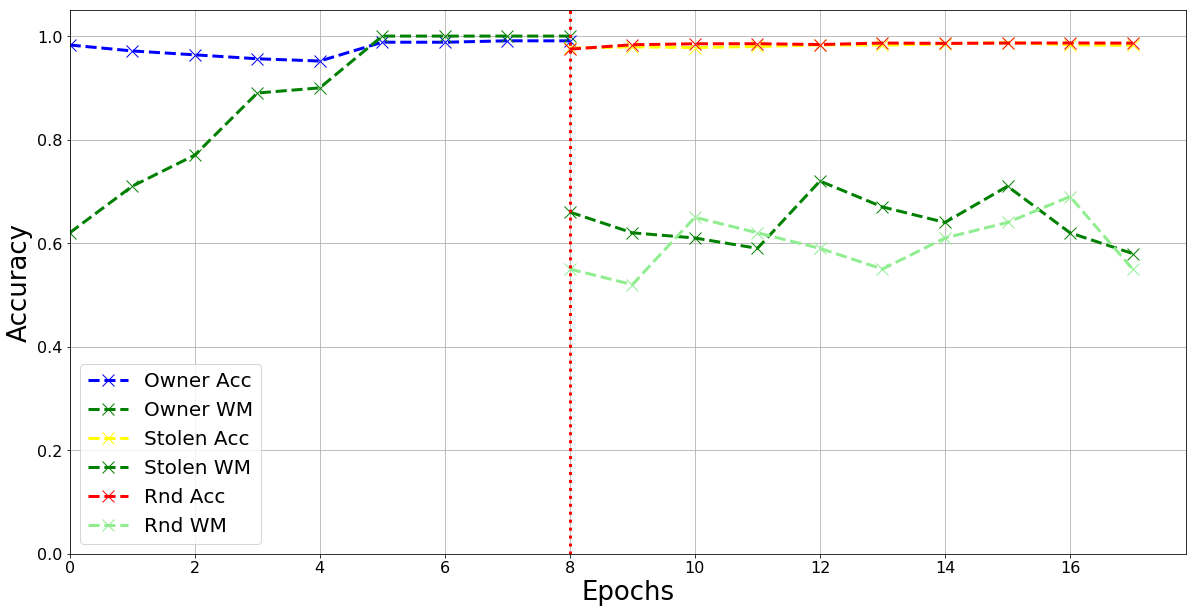

In [10]:
# Plot graphs 
all_history = (history, stolen_history, rnd_history)

plt.figure(figsize=(20, 10))
params = {'legend.fontsize': 20, 'legend.handlelength': 2, 'font.size': 16}
plt.rcParams.update(params)
color_original_acc = "blue"
color_original_wm = "green"

color_stolen_acc = "yellow"
color_stolen_wm = "green"

color_rnd_acc = "red"
color_rnd_wm = "lightgreen"


linestyle_test_acc = "x-"
linestyle_watermark = "x--"
fontsize_data_labels = 16
linewidth = 3.0
markersize = 12

plt.xlabel('Epochs', fontsize=26)
plt.ylabel('Accuracy', fontsize=26)

o = len(history.history['val_acc'])-1

original_acc_x, original_acc_y = np.arange(len(history.history['val_acc'])), history.history['val_acc']
original_acc_line = plt.plot(original_acc_x,
             original_acc_y,
             linestyle_watermark,
             linewidth=linewidth,
             markersize=markersize,
             color=color_original_acc)

original_wm_x, original_wm_y = np.arange(len(history.history['watermark_val'])), history.history['watermark_val']
original_wm_line = plt.plot(original_wm_x,
             original_wm_y,
             linestyle_watermark,
             linewidth=linewidth,
             markersize=markersize,
             color=color_original_wm)

stolen_acc_x, stolen_acc_y = np.arange(o,o+len(stolen_history.history['val_acc'])), stolen_history.history['val_acc']
stolen_acc_line = plt.plot(stolen_acc_x,
             stolen_acc_y,
             linestyle_watermark,
             linewidth=linewidth,
             markersize=markersize,
             color=color_stolen_acc)

stolen_wm_x, stolen_wm_y = np.arange(o,o+len(stolen_history.history['watermark_val'])), stolen_history.history['watermark_val']
stolen_wm_line = plt.plot(stolen_wm_x,
             stolen_wm_y,
             linestyle_watermark,
             linewidth=linewidth,
             markersize=markersize,
             color=color_stolen_wm)

rnd_acc_x, rnd_acc_y = np.arange(o,o+len(rnd_history.history['val_acc'])), rnd_history.history['val_acc']
rnd_acc_line = plt.plot(rnd_acc_x,
             rnd_acc_y,
             linestyle_watermark,
             linewidth=linewidth,
             markersize=markersize,
             color=color_rnd_acc)

rnd_wm_x, rnd_wm_y = np.arange(o,o+len(rnd_history.history['watermark_val'])), rnd_history.history['watermark_val']
rnd_wm_line = plt.plot(rnd_wm_x,
             rnd_wm_y,
             linestyle_watermark,
             linewidth=linewidth,
             markersize=markersize,
             color=color_rnd_wm)

plt.axvline(o,
                linestyle=':',
                linewidth=linewidth,
                color='red')



plt.ylim(0, 1.05)
plt.xlim(0)

plt.grid()

plt.legend(['Owner Acc', 'Owner WM', 'Stolen Acc', 'Stolen WM', 'Rnd Acc', 'Rnd WM'],
           loc='lower left')
plt.show()
    

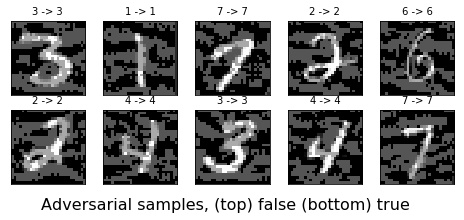

In [13]:
# Plot adversarial samples
to_plot = [*trigger['keys'][0][10:15], *trigger['keys'][0][80:85]]
labels = [3, 1, 7 ,2 ,6 ,2 ,4 ,3 ,4, 7]
new_labels = np.argmax([*trigger['keys'][1][10:15], *trigger['keys'][1][80:85]], axis=1)

fig = plt.figure(figsize=(8, 3))
for i in range(0, 10):
    ax = plt.subplot(2, 5, 1 + i, xticks=[], yticks=[])
    plt.title('{} -> {}'.format(labels[i], new_labels[i]), fontsize=10)
    plt.imshow(np.reshape(to_plot[i], (28, 28)), cmap='gray')

fig.suptitle("Adversarial samples, (top) false (bottom) true", fontsize=16, y=0.06)
plt.show()

     Found cached training data for owner_data3500025000
     Found cached training data for attacker_data3500025000
[1 0 0 0 1 1 1 0 0 0]
[0 4 5 6]
[1 2 3 7 8 9]
[3, 1, 8, 6, 6, 5, 0, 6, 6, 3, 0, 8, 6, 9, 6, 4, 6, 4, 7, 4, 1, 8, 5, 6, 5, 5, 8, 0, 4, 0, 5, 4, 1, 0, 3, 1, 8, 3, 4, 8, 0, 6, 4, 5, 4, 5, 6, 9, 6, 0, 0, 9, 4, 2, 0, 6, 3, 5, 1, 0, 8, 7, 9, 3, 7, 7, 3, 4, 1, 8, 5, 0, 6, 1, 0, 1, 0, 4, 0, 0, 4, 8, 4, 2, 6, 5, 6, 0, 2, 9, 3, 5, 8, 1, 5, 2, 6, 4, 4, 6, 8, 0, 0, 5, 6, 4, 8, 4, 8, 4, 6, 0, 4, 6, 8, 3, 4, 6, 1, 3, 6, 8, 5, 0, 5, 4, 9, 3, 4, 2, 0, 1, 1, 5, 6, 5, 4, 5, 7, 2, 5, 4, 8, 0, 5, 1, 6, 2, 0, 4, 1, 2, 6, 0, 4, 3, 1, 4, 4, 5, 6, 6, 6, 9, 9, 3, 9, 4, 4, 1, 0, 4, 4, 3, 4, 2, 0, 5, 0, 6, 0, 5, 8, 5, 5, 6, 2, 6, 0, 0, 4, 1, 8, 4, 9, 6, 5, 0, 6, 6, 4, 0, 0, 5, 9, 4, 8, 0, 6, 9, 3, 5, 0, 5, 4, 6, 7, 2, 8, 8, 5, 7, 2, 0, 6, 4, 0, 0, 4, 2, 6, 0, 9, 0, 2, 6, 3, 1, 3, 2, 6, 8, 5, 0, 2, 6, 2, 0, 6, 9, 0, 5, 5, 5, 6, 4, 8, 8, 4, 2, 3, 1, 5, 5, 0, 6, 1, 0, 5, 4, 5, 9, 1, 3, 2, 9, 4, 5, 7,

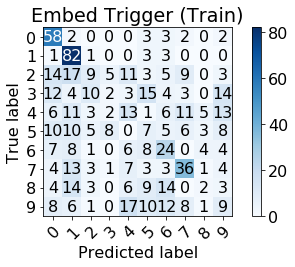

=> watermark_val: 0.3457142860548837
Epoch 2/5
700/700 [==============================] - 2s 3ms/step - loss: 1.7540 - acc: 0.4086 - val_loss: 0.3740 - val_acc: 0.8973
=> Time: : 2.0258798599243164
Confusion matrix, without normalization


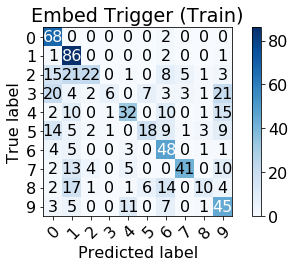

=> watermark_val: 0.5371428571428571
Epoch 3/5
700/700 [==============================] - 2s 3ms/step - loss: 1.2988 - acc: 0.6214 - val_loss: 0.3018 - val_acc: 0.9121
=> Time: : 2.283613681793213
Confusion matrix, without normalization


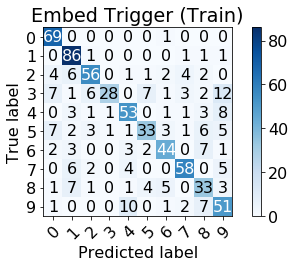

=> watermark_val: 0.730000001021794
Epoch 4/5
700/700 [==============================] - 2s 3ms/step - loss: 0.7982 - acc: 0.7700 - val_loss: 0.2669 - val_acc: 0.9127
=> Time: : 2.162184953689575
Confusion matrix, without normalization


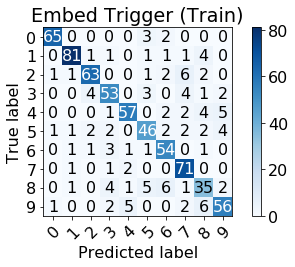

=> watermark_val: 0.8299999996594021
Epoch 5/5
700/700 [==============================] - 2s 3ms/step - loss: 0.5168 - acc: 0.8414 - val_loss: 0.2659 - val_acc: 0.9206
=> Time: : 2.171937942504883
Confusion matrix, without normalization


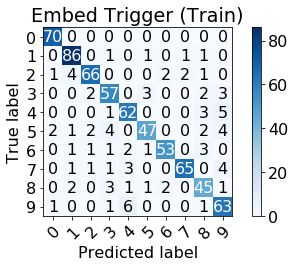

=> watermark_val: 0.8771428568022591
[  0   1   2   3   5   7   8   9  10  13  14  15  16  17  19  20  21  22
  25  26  27  28  30  31  32  33  34  35  36  37  39  40  41  42  43  44
  45  46  47  48  50  51  52  55  57  58  59  60  61  63  64  66  67  68
  69  70  73  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  97  98  99 102 104 105 106 107 108 110 111 112
 113 114 115 116 117 118 119 122 123 124 125 126 127 128 129 130 131 133
 135 136 137 138 139 141 142 143 145 146 147 149 152 153 154 155 156 157
 159 161 162 163 164 165 166 167 168 169 171 173 174 175 176 177 179 181
 182 183 184 185 186 187 189 190 191 192 193 194 195 196 197 198 199 200
 201 202 203 204 205 207 208 210 213 215 216 217 218 219 220 221 222 225
 226 227 229 230 231 232 234 235 236 237 239 240 241 242 244 245 246 247
 249 250 252 253 254 255 257 258 259 260 261 262 265 266 267 269 270 272
 273 274 276 277 279 280 281 282 283 284 285 286 287 288 289 290 292 293
 294 295 296 2

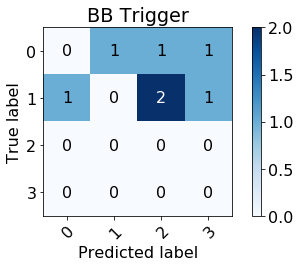

<class 'dict'>
watermark
=> watermark_val: 0.5714285714285714
Epoch 2/20
25000/25000 [==============================] - 14s 542us/step - loss: 0.4979 - acc: 0.9128 - val_loss: 0.2464 - val_acc: 0.9219
=> Time: : 13.542861938476562
Confusion matrix, without normalization


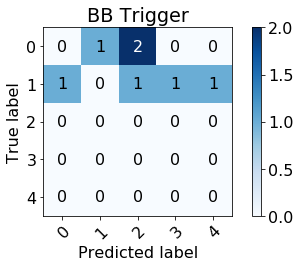

<class 'dict'>
watermark
=> watermark_val: 0.7142857142857143
Epoch 3/20
25000/25000 [==============================] - 14s 540us/step - loss: 0.4741 - acc: 0.9190 - val_loss: 0.2609 - val_acc: 0.9313
=> Time: : 13.505995035171509
Confusion matrix, without normalization


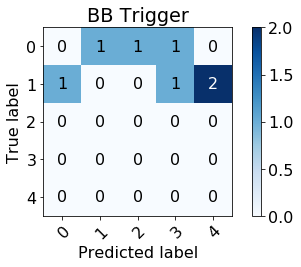

<class 'dict'>
watermark
=> watermark_val: 0.8571428571428571
Epoch 4/20
25000/25000 [==============================] - 14s 541us/step - loss: 0.4602 - acc: 0.9223 - val_loss: 0.2732 - val_acc: 0.9203
=> Time: : 13.516119718551636
Confusion matrix, without normalization


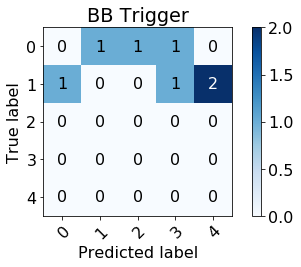

<class 'dict'>
watermark
=> watermark_val: 0.8571428571428571
Epoch 5/20
15936/25000 [==================>...........] - ETA: 4s - loss: 0.4507 - acc: 0.9260

KeyboardInterrupt: 

In [12]:
blackmarks_embed_fn = blackmarks_embed(np.array([1, 0, 1, 0, 0, 1, 1]))
surr_model, all_history = adversarial_blackbox(
     load_dataset_func=load_mnist_images,  # Which dataset to choose. Should return training and testing data
     dataset_label="MNIST",  # Label of the dataset (for caching)
     load_wm_model_func=get_lenet_model_for_mnist,  # Model specification for wm_embedding
     wm_embed_func=blackmarks_embed_fn,
     cluster=True # Set to true when using blackmarks
)

In [ ]:
plot_blackbox(all_history)

### 1. Watermark, Blackbox, Watermark

#### Watermark retention BEFORE embeding new watermark

Trigger Dataset Accuracy: 48%

Test Dataset Accuracy: 97%

#### Watermark retention AFTER embeding new watermark

Trigger Dataset Accuracy: 56%

Test Dataset Accuracy: 98%

### 2. Watermark, Randomized Blackbox

Trigger Dataset Accuracy: 55%

Test Dataset Accuracy: 97.6%